# Archive

## HER 

- HER is an algorithm that works with off-policy methods (SAC,TQC, TD3 and DDPG)
- HER is no longer a separate algorithm but a replay buffer class HerReplayBuffer that must be passed to an off-policy algorithm when using MultiInputPolicy (to have Dict observation support).
- HER requires the environment to inherits from gym.GoalEnv
- For performance reasons, the maximum number of steps per episodes must be specified. In most cases, it will be inferred if you specify max_episode_steps when registering the environment or if you use a gym.wrappers.TimeLimit (and env.spec is not None). Otherwise, you can directly pass max_episode_length to the model constructor

### Train

### Eval 

### Tuning TD3

In [ ]:
import optuna
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import RecordEpisodeStatistics
from wandb.integration.sb3 import WandbCallback


def sample_td3_params(trial: optuna.Trial):
    """
    Sampler for TD3 hyperparams.
    :param trial:
    :return:
    """
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 100, 128, 200])
    buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)])
    # Polyak coeff
    tau = trial.suggest_categorical("tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08])

    #train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512])
    #gradient_steps = train_freq
    #learning_starts = trial.suggest_int('learning_starts', 0, 200, 10)  #default: 100


    noise_type = trial.suggest_categorical("noise_type", ["ornstein-uhlenbeck", "normal", None])
    noise_std = trial.suggest_uniform("noise_std", 0, 1)

    # NOTE: Add "verybig" to net_arch when tuning HER
    net_arch = trial.suggest_categorical("net_arch", ["small", "medium", "big"])
    # activation_fn = trial.suggest_categorical('activation_fn', [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU])

    net_arch = {
        "small": [64, 64],
        "medium": [256, 256],
        "big": [400, 300],
        # Uncomment for tuning HER
        # "verybig": [256, 256, 256],
    }[net_arch]

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        #"train_freq": train_freq,
        #"gradient_steps": gradient_steps,
        "policy_kwargs": dict(net_arch=net_arch),
        "tau": tau,
    }
    
    n_actions = 12      
    if noise_type == "normal":
        hyperparams["action_noise"] = NormalActionNoise(
            mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions)
        )
    elif noise_type == "ornstein-uhlenbeck":
        hyperparams["action_noise"] = OrnsteinUhlenbeckActionNoise(
            mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions)
        )

    return hyperparams




def optimize_agent_td3(trial):
    """ Train the model and optimize
        Optuna maximises the negative log likelihood, so we
        need to negate the reward here
    """
   
    
    model_params = sample_td3_params(trial)
    
    # init tracking experiment.
    # hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number
    wandb.init(
        project="RL-optuna",
        entity="jlu237", 
        sync_tensorboard=True,
        config=config,
        tags=["TD3"],
        reinit=True
    )
    
    env = make('VPPBiddingEnv-TRAIN-v1', render_mode=None)
    env = Monitor(env) 
    env = RecordEpisodeStatistics(env) # record stats such as returns
    
    
    model = TD3('MultiInputPolicy', env, verbose=0, tensorboard_log=f"runs/td3", seed = 1, **model_params)

    model.learn(total_timesteps=2785,
                log_interval=1,
                callback=WandbCallback(
                    gradient_save_freq=1,
                    verbose=0))

    wandb.finish()
    
study = optuna.create_study()
try:
    study.optimize(optimize_agent_td3, n_trials=20)
except KeyboardInterrupt:
    print('Interrupted by keyboard.')

## Contrib packages: ARS

### Train

### Eval 

## Tuning DDPG

### Parameters

- policy = "MlpPolicy" , "CnnPolicy" , "MultiInputPolicy"
- **learning_rate** = staic or range(1,0)
- buffer_size (int) – size of the replay buffer
- **learning_starts (int)** – how many steps of the model to collect transitions for before learning starts
    -  For a fixed number of steps at the beginning (set with the start_steps keyword argument), the agent takes actions which are sampled from a uniform random distribution over valid actions. After that, it returns to normal DDPG exploration.
- batch_size (int) – Minibatch size for each gradient update
- **tau (float)** – the soft update coefficient (“Polyak update”, between 0 and 1)
- gamma (float) – the discount factor
- train_freq (Union[int, Tuple[int, str]]) – Update the model every train_freq steps. Alternatively pass a tuple of frequency and unit like (5, "step") or (2, "episode").
- gradient_steps (int) – How many gradient steps to do after each rollout (see train_freq) Set to -1 means to do as many gradient steps as steps done in the environment during the rollout.
- action_noise (Optional[ActionNoise]) – the action noise type (None by default), this can help for hard exploration problem. Cf common.noise for the different action noise type.
    -  uncorrelated, mean-zero Gaussian noise works perfectly well. 
    -  To facilitate getting higher-quality training data, you may reduce the scale of the noise over the course of training. (We do not do this in our implementation, and keep noise scale fixed throughout.)


- replay_buffer_class (Optional[ReplayBuffer]) – Replay buffer class to use (for instance HerReplayBuffer). If None, it will be automatically selected.
- optimize_memory_usage (bool) – Enable a memory efficient variant of the replay buffer at a cost of more complexity. See https://github.com/DLR-RM/stable-baselines3/issues/37#issuecomment-637501195
- create_eval_env (bool) – Whether to create a second environment that will be used for evaluating the agent periodically. (Only available when passing string for the environment)

- seed (Optional[int]) – Seed for the pseudo random generators
- _init_setup_model (bool) – Whether or not to build the network at the creation of the instance





stable_baselines3.ddpg.MlpPolicy Parameters
- lr_schedule (Callable[[float], float]) – Learning rate schedule (could be constant)
- n_critics (int) – Number of critic networks to create.

stable_baselines3.ddpg.MlpPolicy.set_training_mode()
- mode (bool) – if true, set to training mode, else set to evaluation mode

stable_baselines3.ddpg.CnnPolicy

stable_baselines3.ddpg.MultiInputPolicy


In [ ]:
# hide all deprecation warnings from tensorflow
#import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import optuna

#from stable_baselines import PPO2
from stable_baselines3 import DDPG
from stable_baselines3 import HerReplayBuffer
from gym.wrappers import RecordEpisodeStatistics
from stable_baselines3.common.noise import NormalActionNoise
#from stable_baselines.common.evaluation import evaluate_policy
#from stable_baselines.common.cmd_util import make_vec_env

# https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/5_custom_gym_env.ipynb
#from custom_env import GoLeftEnv

# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
normal_action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))


def optimize_ddpg(trial):
    """ Learning hyperparamters we want to optimise"""
    
    replay_buffer_class = trial.suggest_categorical("replay_buffer_class", ["HER", "None"])
    replay_buffer_class = {"HER": HerReplayBuffer, "None": None}[replay_buffer_class]
    
    action_noise = trial.suggest_categorical("action_noise", ["action_noise", "None"])
    action_noise = {"action_noise": normal_action_noise, "None": None}[action_noise]
    
    params =  {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 1.0), #default: 0.001
        'learning_starts': int(trial.suggest_int('learning_starts', 0, 200, 10)),  #default: 100
        'batch_size': int(trial.suggest_int('batch_size', 0, 200,10)),  #default: 100
        'tau': trial.suggest_loguniform('tau', 0.001, 1.0), #default: 0.005
        'gamma': trial.suggest_loguniform('gamma', 0.9, 0.9999), # default: gamma=0.99
        'replay_buffer_class' : replay_buffer_class,
        'action_noise' : action_noise
    }
    
    return params
        



def optimize_agent(trial):
    """ Train the model and optimize
        Optuna maximises the negative log likelihood, so we
        need to negate the reward here
    """
    
    model_params = optimize_ddpg(trial)
    
    # init tracking experiment.
    # hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number
    wandb.init(
        project="RL-optuna",
        entity="jlu237", 
        sync_tensorboard=True,
        config=config,
        reinit=True
    )
    
    env = make('VPPBiddingEnv-TRAIN-v1', render_mode=None)
    env = Monitor(env) 
    env = RecordEpisodeStatistics(env) # record stats such as returns


    model = DDPG('MultiInputPolicy', env, verbose=0, tensorboard_log=f"runs/ddpg", seed = 1, **model_params)
    model.learn(total_timesteps=557, log_interval=1)
    
    wandb.finish()
    
study = optuna.create_study()
try:
    study.optimize(optimize_agent, n_trials=20)
except KeyboardInterrupt:
    print('Interrupted by keyboard.')

In [ ]:
env = make('VPPBiddingEnv-TRAIN-v1', render_mode=None)
env.observation_space.spaces["observation"]

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


In [ ]:
model.get_parameters()["critic.optimizer"]["param_groups"]

In [ ]:
model.get_parameters()["actor.optimizer"]["param_groups"]

In [ ]:
# !apt-get install swig cmake ffmpeg freeglut3-dev xvfb

In [ ]:
# Alternative from araffin for optuna from: https://github.com/optuna/optuna-examples/blob/52ed3aff3e3e936be3873b5acc6ee3ccdadea914/rl/sb3_simple.py#L60

""" Optuna example that optimizes the hyperparameters of
a reinforcement learning agent using A2C implementation from Stable-Baselines3
on a OpenAI Gym environment.

This is a simplified version of what can be found in https://github.com/DLR-RM/rl-baselines3-zoo.

You can run this example as follows:
    $ python sb3_simple.py

"""
from typing import Any
from typing import Dict

import gym
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import EvalCallback
import torch
import torch.nn as nn


N_TRIALS = 100
N_STARTUP_TRIALS = 5
N_EVALUATIONS = 2
N_TIMESTEPS = int(2e4)
EVAL_FREQ = int(N_TIMESTEPS / N_EVALUATIONS)
N_EVAL_EPISODES = 3

ENV_ID = "CartPole-v1"

DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}


def sample_a2c_params(trial: optuna.Trial) -> Dict[str, Any]:
    """Sampler for A2C hyperparameters."""
    gamma = 1.0 - trial.suggest_float("gamma", 0.0001, 0.1, log=True)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.3, 5.0, log=True)
    gae_lambda = 1.0 - trial.suggest_float("gae_lambda", 0.001, 0.2, log=True)
    n_steps = 2 ** trial.suggest_int("exponent_n_steps", 3, 10)
    learning_rate = trial.suggest_float("lr", 1e-5, 1, log=True)
    ent_coef = trial.suggest_float("ent_coef", 0.00000001, 0.1, log=True)
    ortho_init = trial.suggest_categorical("ortho_init", [False, True])
    net_arch = trial.suggest_categorical("net_arch", ["tiny", "small"])
    activation_fn = trial.suggest_categorical("activation_fn", ["tanh", "relu"])

    # Display true values
    trial.set_user_attr("gamma_", gamma)
    trial.set_user_attr("gae_lambda_", gae_lambda)
    trial.set_user_attr("n_steps", n_steps)

    net_arch = [
        {"pi": [64], "vf": [64]} if net_arch == "tiny" else {"pi": [64, 64], "vf": [64, 64]}
    ]

    activation_fn = {"tanh": nn.Tanh, "relu": nn.ReLU}[activation_fn]

    return {
        "n_steps": n_steps,
        "gamma": gamma,
        "gae_lambda": gae_lambda,
        "learning_rate": learning_rate,
        "ent_coef": ent_coef,
        "max_grad_norm": max_grad_norm,
        "policy_kwargs": {
            "net_arch": net_arch,
            "activation_fn": activation_fn,
            "ortho_init": ortho_init,
        },
    }


class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        eval_env: gym.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):

        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True


def objective(trial: optuna.Trial) -> float:

    kwargs = DEFAULT_HYPERPARAMS.copy()
    # Sample hyperparameters
    kwargs.update(sample_a2c_params(trial))
    # Create the RL model
    model = A2C(**kwargs)
    # Create env used for evaluation
    eval_env = gym.make(ENV_ID)
    # Create the callback that will periodically evaluate
    # and report the performance
    eval_callback = TrialEvalCallback(
        eval_env, trial, n_eval_episodes=N_EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
    )

    nan_encountered = False
    try:
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN
        print(e)
        nan_encountered = True
    finally:
        # Free memory
        model.env.close()
        eval_env.close()

    # Tell the optimizer that the trial failed
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward


if __name__ == "__main__":
    # Set pytorch num threads to 1 for faster training
    torch.set_num_threads(1)

    sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
    # Do not prune before 1/3 of the max budget is used
    pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3)

    study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
    try:
        study.optimize(objective, n_trials=N_TRIALS, timeout=600)
    except KeyboardInterrupt:
        pass

    print("Number of finished trials: ", len(study.trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    print("  User attrs:")
    for key, value in trial.user_attrs.items():
        print("    {}: {}".format(key, value))

In [ ]:
# code from https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/utils/hyperparams_opt.py#L340

def sample_ddpg_params(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DDPG hyperparams.
    :param trial:
    :return:
    """
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 100, 128, 256, 512, 1024, 2048])
    buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(1e5), int(1e6)])
    # Polyak coeff
    tau = trial.suggest_categorical("tau", [0.001, 0.005, 0.01, 0.02, 0.05, 0.08])

    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 32, 64, 128, 256, 512])
    gradient_steps = train_freq

    noise_type = trial.suggest_categorical("noise_type", ["ornstein-uhlenbeck", "normal", None])
    noise_std = trial.suggest_uniform("noise_std", 0, 1)

    # NOTE: Add "verybig" to net_arch when tuning HER (see TD3)
    net_arch = trial.suggest_categorical("net_arch", ["small", "medium", "big"])
    # activation_fn = trial.suggest_categorical('activation_fn', [nn.Tanh, nn.ReLU, nn.ELU, nn.LeakyReLU])

    net_arch = {
        "small": [64, 64],
        "medium": [256, 256],
        "big": [400, 300],
    }[net_arch]

    hyperparams = {
        "gamma": gamma,
        "tau": tau,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "policy_kwargs": dict(net_arch=net_arch),
    }

    if noise_type == "normal":
        hyperparams["action_noise"] = NormalActionNoise(
            mean=np.zeros(trial.n_actions), sigma=noise_std * np.ones(trial.n_actions)
        )
    elif noise_type == "ornstein-uhlenbeck":
        hyperparams["action_noise"] = OrnsteinUhlenbeckActionNoise(
            mean=np.zeros(trial.n_actions), sigma=noise_std * np.ones(trial.n_actions)
        )

    if trial.using_her_replay_buffer:
        hyperparams = sample_her_params(trial, hyperparams)

    return hyperparams


In [ ]:
!git clone --recursive https://github.com/DLR-RM/rl-baselines3-zoo

In [ ]:
#!cd rl-baselines3-zoo/

In [ ]:
!pip install -r rl-baselines3-zoo/requirements.txt

In [ ]:
!python rl-baselines3-zoo/train.py --algo ddpg --env VPPBiddingEnv-TRAIN-v1 -n 697 -optimize --n-trials 5 --n-jobs -1 \
  --sampler tpe --pruner median

In [ ]:
!python rl-baselines3-zoo/scripts/parse_study.py -i path/to/study.pkl --print-n-best-trials 10 --save-n-best-hyperparameters 10


### PPO - Proximal Policy Optimization algorithm 

#### Train the agent

#### Evaluate Agent

## A2C - synchronous, deterministic variant of Asynchronous Advantage Actor Critic (A3C)

#### Training

#### Eval

## Other Algorithm 

In [ ]:
# todo

## DQN -- needs Discrete Action Space. 

# Testing

#### Run Episodes

### Check the Environment

# Keras 

## 2. Create a Deep Learning Model with Keras

## 3. Build Agent with Keras-RL


## 4. Reloading Agent from Memory


# Archive


### 2. create test list , check if date is in test list, if yes, skip day 

1. data set start date = 01.07.2020
2. training start date = 02.07.2020 
3. first slot lower boundary = 02.07.2020 22.00
4. make test set 
    - take time_features_df
    - substract 2 hours from each timestamp = start of slot 
    - iterate over df and get date every 5 days, add to list = test list. 
5. in training mode -> skip dates in list. 
6. in test mode -> take only dates from test list. 
7. unterschiedliche testsets erstellen? izzy meinte, zusammenhängende woche wäre gut (seasonality)

Vorgehen:
Ab der ersten Vollen Woche: Woche nehmen und Testset-Liste hinzufügen, 
dann skip 5 wochen , dann 1 woche test woche 


### scaler for observations


In [ ]:
# scaler for observations

scaler = MinMaxScaler(feature_range=(-1,1))

a_raw = asset_data_historic
print("a_raw")

print(a_raw)

scaler.fit(np.array(a_raw).reshape(-1, 1))

b_transformed = scaler.transform((a_raw.reshape(-1, 1)))
print("b_transformed")

print(b_transformed)

# convert from array to list
c_list = [x for xs in list(b_transformed) for x in xs]
print("c_list")

print(c_list)

# transform back to 

d_transformed_back = (scaler.inverse_transform(np.array(c_list).reshape(-1, 1)))
print("d_transformed_back")
print(d_transformed_back)

print("e_array")
e_array = d_transformed_back.flatten()
print(e_array)


print("f_list")
f_list = [x for xs in list(d_transformed_back) for x in xs]

print(f_list)

 # MAX AT 10 

maximum_possible_VPP_capacity = 131
capacity_to_deliver = 30
mean = 0.0
sd = 9.9
max_power = 30
max_at_10_percent = 0.016790447072007098
scale_factor = 59.557675606338805


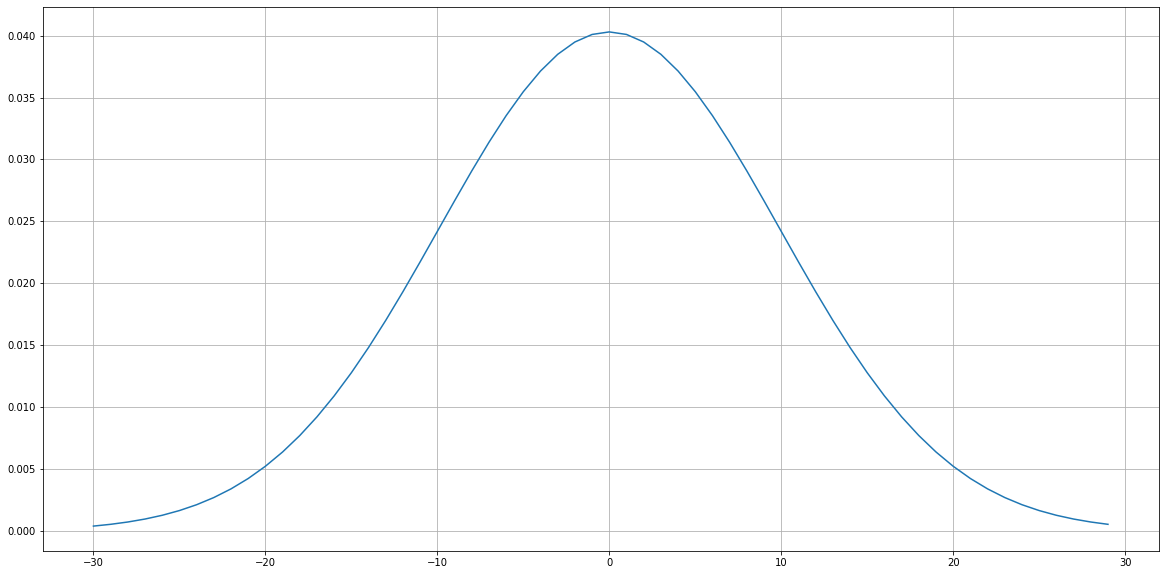

In [71]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np 

maximum_possible_VPP_capacity = 131
print("maximum_possible_VPP_capacity = " + str(maximum_possible_VPP_capacity))


capacity_to_deliver = 30
print("capacity_to_deliver = " + str(capacity_to_deliver))



mean = 0. # symmetrical normal distribution at 0 #
print("mean = " + str(mean))

sd = capacity_to_deliver * 0.33 # std of Hydro1 and Hydro2 = 0.33 #maximum_possible_VPP_capacity / 7 # 5.10

print("sd = " + str(sd))

max_power = capacity_to_deliver
print("max_power = " + str(max_power))

max_at_10_percent = norm.pdf((maximum_possible_VPP_capacity*0.1),mean,sd)
print("max_at_10_percent = " + str(max_at_10_percent))

scale_factor = 1 / max_at_10_percent
print("scale_factor = " + str(scale_factor))


# Plot between -max_power and max_power with .001 steps.
x_axis = np.arange(-max_power, max_power, 1)
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
#ax.set_xticks(np.arange(-140, 140, 10))
#ax.set_yticks(np.arange(-10, + 10, 0.1))
#x1, y1 = [-max_power, max_power],[1, 1]
#x2, y2 = [max_power * 0.1, max_power * 0.1],[0, 1]
plt.plot(x_axis, (norm.pdf(x_axis, mean, sd)))
plt.grid()
plt.show()

# das maximum der normalverteilung = mean soll bei 10 liegen 

# DOUBLE 

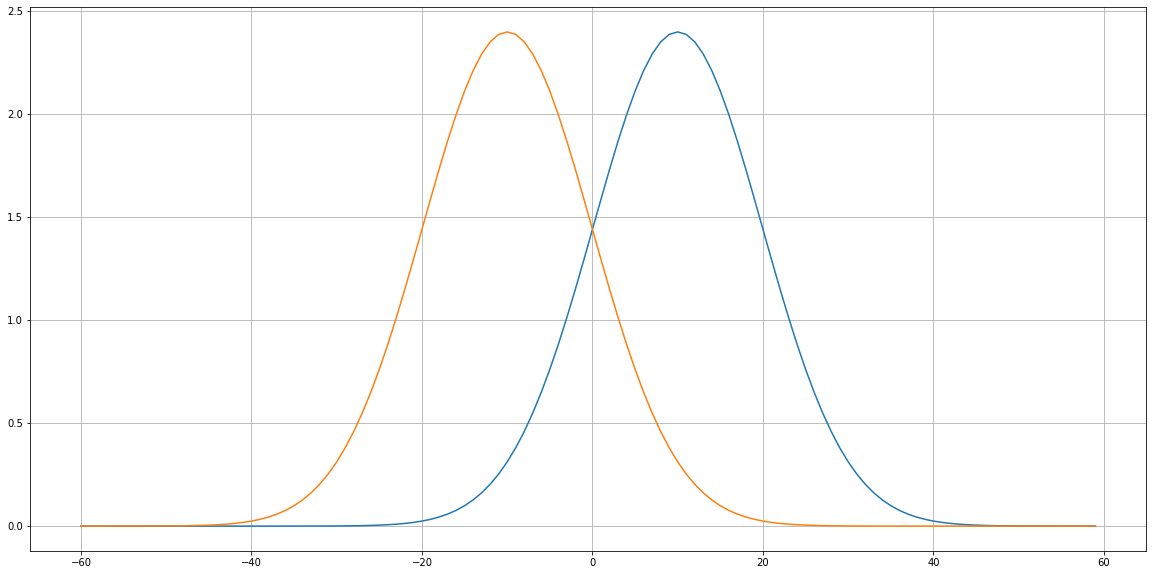

In [74]:

# Plot between -max_power and max_power with .001 steps.
x_axis = np.arange(-max_power*2, max_power*2, 1)
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
#ax.set_xticks(np.arange(-140, 140, 10))
#x1, y1 = [-max_power, max_power],[1, 1]
#x2, y2 = [max_power * 0.1, max_power * 0.1],[0, 1]

mean1 = 10
mean2 = -10

plt.plot(x_axis,
         (norm.pdf(x_axis,loc=mean1 , scale=sd) * scale_factor) ,
        ) 
plt.plot(x_axis,
         (norm.pdf(x_axis,loc=mean2 , scale=sd) * scale_factor),
        )
plt.grid()
plt.show()


In [51]:
import random 

if capacity_to_deliver < 0:
    mean = -10 
if capacity_to_deliver > 0:
    mean = 10
    
propab_of_activation = round(float(norm.pdf(x=capacity_to_deliver, loc=mean,scale=sd) * scale_factor),3)
print("propab_of_activation = " + str(propab_of_activation))

activation_possible = random.choices(
            population=[True, False],
            weights=   [propab_of_activation , (1-propab_of_activation)],
            k=1
        )

activation_possible[0] 

capacity_to_deliver = 30
propab_of_activation = 0.0


False

## SHIFT 

In [ ]:

# Plot between -max_power and max_power with .001 steps.
x_axis = np.arange(-max_power, max_power, 1)
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
ax.set_xticks(np.arange(-140, 140, 10))
ax.set_yticks(np.arange(-10, + 10, 0.1))
x1, y1 = [-max_power, max_power],[1, 1]
x2, y2 = [max_power * 0.1, max_power * 0.1],[0, 1]
plt.plot(x_axis, 
         (norm.pdf(x_axis, mean, sd)) * scale_factor + shift_to_100,
        x1, y1,x2, y2 )
plt.grid()
plt.show()


In [17]:
capacity_to_deliver = 30
print("capacity_to_deliver = " + str(capacity_to_deliver))


propab_of_activation = round(float(norm.pdf(x=capacity_to_deliver, loc=mean,scale=sd) * scale_factor),3)
print("propab_of_activation = " + str(propab_of_activation))


capacity_to_deliver = 30
propab_of_activation = 0.277


In [47]:

probab= [0.05, 0.1,  0.15, 0.2,  0.25,  0.5,   0.75,  1.0]
a = [0.675, 0.23, 0.06, 0.02, 0.01, 0.002, 0.002, 0.001]

pop = [] 
for i in range(len(a)):
    for j in range(round((a[i]* 100))):
        pop.append(probab[i]*131)
        
        
print(len(pop))
pop

100


[6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,
 6.550000000000001,


In [48]:
print(np.std(pop))



5.105219755309267


In [ ]:
a = [1, 2, 3, 4, 5]
#a_1 = np.array(a)
print(np.std(a))

import statistics
statistics.pstdev(a)



In [ ]:
import random 

weights = [0.675, 0.23, 0.06, 0.02, 0.01, 0.002, 0.002, 0.001]
max_activation_share = random.choices(
            population=[0.05, 0.1,  0.15, 0.2,  0.25,  0.5,   0.75,   1.0],
            weights=weights,
            k=1
        )

capacity_to_deliver = 0. 
capacity_to_deliver = max_activation_share[0] * 100
print(max_activation_share[0])
print(capacity_to_deliver)

In [80]:
propab_of_activation = 0.995 

activation_possible = random.choices(
            population=[True, False],
            weights=   [propab_of_activation , (1-propab_of_activation)],
            k=1
        )
activation_possible[0]

True

In [10]:
vpp_total_step = 3
capacity_to_deliver = -100
not_delivered_capacity = abs((vpp_total_step - abs(capacity_to_deliver)))
not_delivered_capacity


97

In [16]:
not_activated_capacity = 100

# 100 MW / 15 min


# not_activated_capacity = MW
# MW is activated each minute 
# 15 * activation for 30 seconds 
15 * not_activated_capacity

# total 
#15 * 0.5 Minuten = 100 MW / 7.5 minutes
#100 *  0.125 # or 
#100 /  8

# per pos / neg  
# 7.5 * 0.5 Minuten = 100 MW / 3.75 minutes
# 3.75 minutes / 60 minuten = 0.0625h 
# OR 60 minuten / 3.75 minutes = 16
#100 *  0.0625 # OR 
#100 /  16

energy1 = not_activated_capacity * 0.0625
print("energy1 = " + str(energy1))

# * 0.5 / 60 = 30 Seconds 
# multiplied = MWh
# 7.5 = only for negative FCR = half of 15minutes , other half for positive FCR.  
energy2  = 7.5 * (not_activated_capacity * 0.5/60)  # multiply power with time to get energy 
print("energy2 = " + str(energy2))

    

energy1 = 6.25
energy2 = 6.25


In [14]:
100 *  0.0625
100 /  16

6.25

slots_not_participated = [1, 0, 1, 0, 1, 1]
activated_data = {'Activatedfsfdsfdsfsfsd': [0, 1, 0, 1, 0, 0], 'NOT Activ.sdfsdfdsfds': [0, 0, 0, 0, 0, 0], 'lost/not part./ not res.': [1, 0, 1, 0, 1, 1]}
activated_df =    Activatedfsfdsfdsfsfsd  NOT Activ.sdfsdfdsfds  lost/not part./ not res.
1                       0                      0                         1
2                       1                      0                         0
3                       0                      0                         1
4                       1                      0                         0
5                       0                      0                         1
6                       0                      0                         1


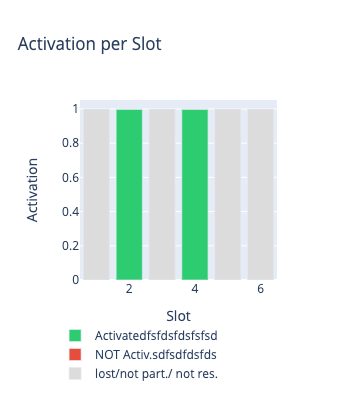

In [133]:
import pandas as pd 
import plotly.express as px

slots_activated = [0, 1, 0, 1, 0, 0]
slots_not_activated = [0, 0, 0, 0, 0, 0]
slots_not_participated = [1, 0, 1, 0, 1, 1]
print("slots_not_participated = " + str(slots_not_participated))
activated_data = {'Activatedfsfdsfdsfsfsd': slots_activated, 'NOT Activ.sdfsdfdsfds': slots_not_activated, 'lost/not part./ not res.': slots_not_participated}
print("activated_data = " + str(activated_data))
activated_df = pd.DataFrame(data=activated_data, index=[1, 2, 3, 4, 5, 6])
print("activated_df = " + str(activated_df))

activated_plot = px.bar(activated_df,  x= activated_df.index, y=['Activatedfsfdsfdsfsfsd', 'NOT Activ.sdfsdfdsfds', 'lost/not part./ not res.'], color_discrete_sequence=[ "#2ECC71", "#E74C3C", "gainsboro"] , labels={"index": "Slot", "value": "Activation"}, title="Activation per Slot", width=300, height=400)
activated_plot.update_layout(legend=dict(orientation="h",yanchor="bottom", y=-0.6, xanchor="center", x=0.3,title="" )) 
activated_plot

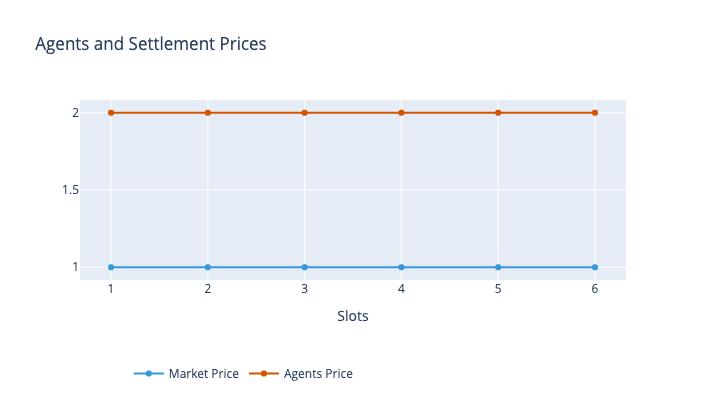

In [138]:
import plotly.graph_objects as go


price_plot = go.Figure()
price_plot.add_trace(go.Scatter(x=list(range(1,7)), y=[1,1,1,1,1,1], line_color="#3498DB", name="Market Price"))
price_plot.add_trace(go.Scatter(x=list(range(1,7)), y=[2,2,2,2,2,2], line_color="#D35400", name="Agents Price" )) 
price_plot.update_layout(width=300, height=400, title="Agents and Settlement Prices", xaxis_title="Slots", legend=dict(orientation="h",yanchor="bottom", y=-0.6, xanchor="center", x=0.3, title=""))



In [139]:
positive_activation_possible_list = []
activation_possible = False

for time_step in range(0, 16):
    positive_activation_possible_list.append(activation_possible)
    activation_possible = True

    
positive_activation_possible_list

[False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [141]:
activation_possible_count = sum(positive_activation_possible_list)
activation_possible_count

15

In [145]:
len(positive_activation_possible_list)

16

0.0016040229612663199
-0.009039479587125641


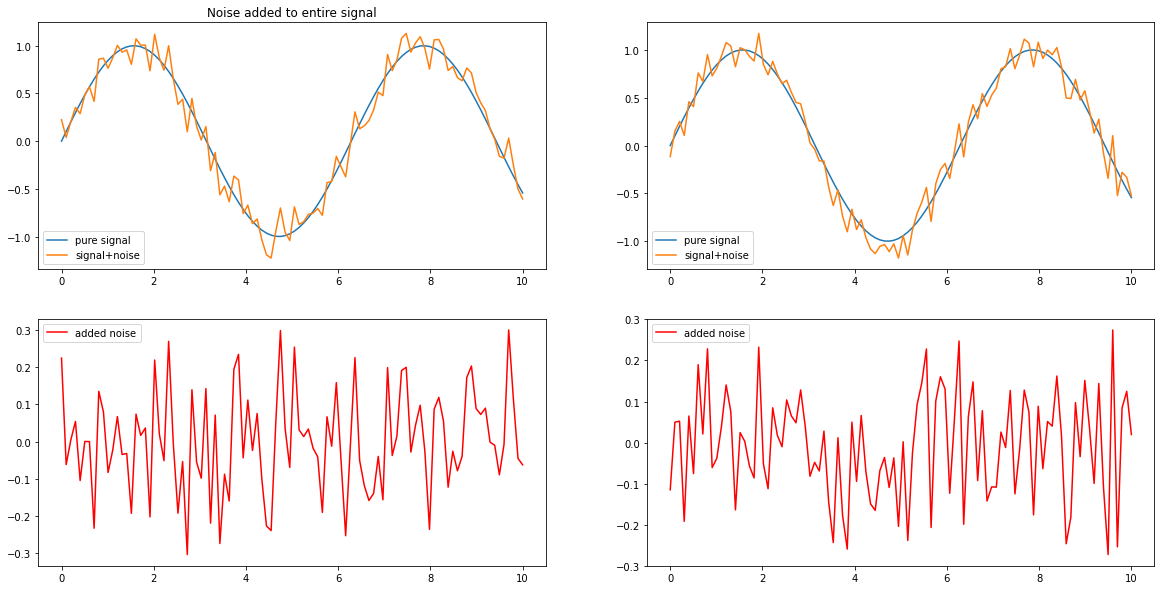

In [62]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(7)
t = np.linspace(0, 10, 100)
data = np.sin(t)

mean = 0 
percentage = 0.2
noise1 = np.random.normal(mean, data.std(), data.size) * percentage
data_noisy_1 = data + noise1

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(221)
ax1.set_title('Noise added to entire signal')
ax1.plot(t, data, label='pure signal')
ax1.plot(t, data_noisy_1, label='signal+noise')
plt.legend()

ax2 = fig.add_subplot(223)
ax2.plot(t, data_noisy_1 - data, label='added noise', c='r')
plt.legend()

standard_deviation = np.std(data)
standard_deviation_gaussian = standard_deviation *  0.2 # for 20% Gaussian noise
noise2 = np.random.normal(mean, standard_deviation_gaussian, size = data.shape)
data_noisy_2 = data + noise2
#data_noisy_2 = data_noisy_2.clip(min=0)

ax3 = fig.add_subplot(222)
ax3.plot(t, data, label='pure signal')
ax3.plot(t, data_noisy_2, label='signal+noise')
plt.legend()

ax4 = fig.add_subplot(224)
ax4.plot(t, data_noisy_2 - data, label='added noise', c='r')
plt.legend()

print(np.mean(data_noisy_1 - data))
print(np.mean(data_noisy_2 - data))


In [112]:
import random 
import numpy as np 
seed = 111111111111111111111

random.seed(seed)
max_activation_share = random.choices(
        population=[0.05, 0.1,  0.15, 0.2,  0.25,  0.5,   0.75,   1.0],
        weights=[0.675, 0.23, 0.06, 0.02, 0.01, 0.002, 0.002, 0.001],
        k=1
    )

print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])
print(max_activation_share[0])

0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15
0.15


In [117]:
[0,1,0,1,0,1].count(1)


3

In [9]:
import numpy as np 
action= np.array([1., -1., 1., -1., -0.5, 0.5, -0.3, 0.3, 1., 1., -1., 1.])

In [18]:
from sklearn.preprocessing import MinMaxScaler


size_scaler = MinMaxScaler(feature_range=(-1,1))

size_scaler.fit(np.array([0.0093454, 2.534144]).reshape(-1, 1))  # type: ignore
print("Size Normalization: size_scaler min = " + str(size_scaler.data_min_) + " and max = " + str(size_scaler.data_max_))

price_scaler = MinMaxScaler(feature_range=(-1,1))
price_scaler.fit(np.array([10., 491.53]).reshape(-1, 1))  # type: ignore
print("Price Normalization: price_scaler min = " + str(price_scaler.data_min_) + " and max = " + str(price_scaler.data_max_))


Size Normalization: size_scaler min = [0.0093454] and max = [2.534144]
Price Normalization: price_scaler min = [10.] and max = [491.53]


In [13]:
bid_sizes_normalized = action[0:6]
bid_prices_normalized = action[6:]


print("bid_sizes_normalized = "  + str(bid_sizes_normalized))
print("bid_prices_normalized = "  + str(bid_prices_normalized))

bid_sizes_converted = size_scaler.inverse_transform(np.array(bid_sizes_normalized).reshape(-1, 1))
bid_prices_converted = price_scaler.inverse_transform(np.array(bid_prices_normalized).reshape(-1, 1))

print("bid_sizes_converted = "  + str(bid_sizes_converted))
print("bid_prices_converted = "  + str(bid_prices_converted))

# convert from 2d array to list 
bid_sizes_converted = [x for xs in list(bid_sizes_converted) for x in xs]
bid_prices_converted = [x for xs in list(bid_prices_converted) for x in xs]

print("bid_sizes_converted = "  + str(bid_sizes_converted))
print("bid_prices_converted = "  + str(bid_prices_converted))


bid_sizes_normalized = [ 1.  -1.   1.  -1.  -0.5  0.5]
bid_prices_normalized = [-0.3  0.3  1.   1.  -1.   1. ]
bid_sizes_converted = [[2.534144  ]
 [0.0093454 ]
 [2.534144  ]
 [0.0093454 ]
 [0.64054505]
 [1.90294435]]
bid_prices_converted = [[178.5355]
 [322.9945]
 [491.53  ]
 [491.53  ]
 [ 10.    ]
 [491.53  ]]
bid_sizes_converted = [2.534144, 0.00934539999999986, 2.534144, 0.00934539999999986, 0.6405450499999998, 1.9029443499999998]
bid_prices_converted = [178.53549999999996, 322.99449999999996, 491.53, 491.53, 9.999999999999988, 491.53]


## different action spaces 

In [52]:
from gym.spaces import Box, Dict, Discrete, MultiDiscrete, Tuple


In [71]:
def _convert_number_to_float(x): 
    return np.float32(x)

action_low = np.array([-1.0] * 12,  dtype=np.float32)
# 6 values to max maximum_possible_FCR_capacity = the bid sizes 
# 6 values to max maximum_possible_market_price = the bid prices
action_high = np.array([1.0] * 6 + [1.0] * 6, dtype=np.float32)

action_low = _convert_number_to_float(action_low)
action_high = _convert_number_to_float(action_high)

current_action_space = Box(low=action_low, high=action_high, shape=(12,), dtype=np.float32)

sample = current_action_space.sample()
print("sample" + str(sample))


bid_sizes_normalized = sample[0:6]
bid_prices_normalized = sample[6:]


print("bid_sizes_normalized = "  + str(bid_sizes_normalized))
print("bid_prices_normalized = "  + str(bid_prices_normalized))

bid_sizes_converted = size_scaler.inverse_transform(np.array(bid_sizes_normalized).reshape(-1, 1))
bid_prices_converted = price_scaler.inverse_transform(np.array(bid_prices_normalized).reshape(-1, 1))

print("bid_sizes_converted = "  + str(bid_sizes_converted))
print("bid_prices_converted = "  + str(bid_prices_converted))

# convert from 2d array to list 
bid_sizes_converted = [x for xs in list(bid_sizes_converted) for x in xs]
bid_prices_converted = [x for xs in list(bid_prices_converted) for x in xs]

print("bid_sizes_converted = "  + str(bid_sizes_converted))
print("bid_prices_converted = "  + str(bid_prices_converted))

sample[-0.9251121   0.53160375  0.3954447  -0.554738    0.86895424 -0.21745825
 -0.22402577  0.82451767  0.7428029   0.18544866  0.9611698  -0.08993536]
bid_sizes_normalized = [-0.9251121   0.53160375  0.3954447  -0.554738    0.86895424 -0.21745825]
bid_prices_normalized = [-0.22402577  0.82451767  0.7428029   0.18544866  0.9611698  -0.08993536]
bid_sizes_converted = [[0.1038838 ]
 [1.9428408 ]
 [1.7709538 ]
 [0.57144386]
 [2.368712  ]
 [0.9972256 ]]
bid_prices_converted = [[196.82744]
 [449.28   ]
 [429.60593]
 [295.41455]
 [482.18106]
 [229.11172]]
bid_sizes_converted = [0.1038838, 1.9428408, 1.7709538, 0.57144386, 2.368712, 0.9972256]
bid_prices_converted = [196.82744, 449.28, 429.60593, 295.41455, 482.18106, 229.11172]


In [77]:
action1 = MultiDiscrete(np.array([[3, 3, 3, 3, 3, 3], [491, 491, 491, 491, 491, 491]]))

sample = action1.sample()
print("sample" + str(sample))

bid_sizes_normalized = sample[0]
bid_prices_normalized = sample[1]


print("bid_sizes_normalized = "  + str(bid_sizes_normalized))
print("bid_prices_normalized = "  + str(bid_prices_normalized))

bid_sizes_converted = np.array(bid_sizes_normalized).reshape(-1, 1)
bid_prices_converted = np.array(bid_prices_normalized).reshape(-1, 1)

print("bid_sizes_converted = "  + str(bid_sizes_converted))
print("bid_prices_converted = "  + str(bid_prices_converted))

# convert from 2d array to list 
bid_sizes_converted = [x for xs in list(bid_sizes_converted) for x in xs]
bid_prices_converted = [x for xs in list(bid_prices_converted) for x in xs]

print("bid_sizes_converted = "  + str(bid_sizes_converted))
print("bid_prices_converted = "  + str(bid_prices_converted))

sample[[  2   1   1   0   0   0]
 [176 343  33  15 355 280]]
bid_sizes_normalized = [2 1 1 0 0 0]
bid_prices_normalized = [176 343  33  15 355 280]
bid_sizes_converted = [[2]
 [1]
 [1]
 [0]
 [0]
 [0]]
bid_prices_converted = [[176]
 [343]
 [ 33]
 [ 15]
 [355]
 [280]]
bid_sizes_converted = [2, 1, 1, 0, 0, 0]
bid_prices_converted = [176, 343, 33, 15, 355, 280]


In [56]:
action2 = Box(low=-1, high=1, shape=(2,6))
action2.sample()

array([[ 0.5708049 , -0.0338879 , -0.72509384,  0.44396704,  0.7842508 ,
         0.7328777 ],
       [ 0.791661  , -0.16967323,  0.7639063 , -0.70096034,  0.5710376 ,
         0.6839441 ]], dtype=float32)

In [57]:
action3 = Box(low=-1, high=1, shape=(6,2))
action3.sample()

array([[-0.3421742 , -0.71422064],
       [ 0.8808228 ,  0.46854025],
       [-0.07741426,  0.41242534],
       [ 0.15616894, -0.12559837],
       [ 0.30357826, -0.994279  ],
       [ 0.97484624, -0.49383703]], dtype=float32)

In [58]:
action4 = Tuple((MultiDiscrete([3, 3, 3, 3, 3, 3]), 
                 Box(low=0, high=400, shape=(6,))))
action4.sample()

(array([1, 1, 2, 0, 0, 2]),
 array([223.67448, 347.23904, 381.58328, 279.9584 , 141.78294, 284.07162],
       dtype=float32))

In [59]:
action5 = Tuple((MultiDiscrete([3, 3, 3, 3, 3, 3]), 
                 Box(low=0, high=400, shape=(6,1))))
action5.sample()

(array([0, 2, 0, 2, 0, 0]),
 array([[381.06955 ],
        [ 53.97784 ],
        [ 62.092716],
        [149.19984 ],
        [201.21953 ],
        [ 60.88009 ]], dtype=float32))

In [60]:
action6 = Dict(
    {
        "price": Box(low=0, high=400, shape=(6,)),
        "size": MultiDiscrete([3, 3, 3, 3, 3, 3])

    }
)

action6.sample()

OrderedDict([('price',
              array([312.49332 , 310.63818 , 211.13991 ,  10.162458, 199.78748 ,
                      95.69986 ], dtype=float32)),
             ('size', array([0, 1, 2, 0, 2, 2]))])

In [61]:
action7 = Dict(
    {
        "price": Box(low=0, high=400, shape=(6,1)),
        "size": MultiDiscrete([3, 3, 3, 3, 3, 3])

    }
)

action7.sample()

OrderedDict([('price',
              array([[172.87299],
                     [194.52568],
                     [195.17354],
                     [ 92.44837],
                     [212.25813],
                     [112.10037]], dtype=float32)),
             ('size', array([2, 2, 2, 2, 2, 0]))])

In [ ]:
import gym
env = gym.make('CarRacing-v1')
env.observation_space.shape

env = FlattenObservation(env)
env.observation_space.shape
obs = env.reset()
